In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import zscore
from scipy.spatial import cKDTree
from sklearn.neighbors import KernelDensity
from esda.moran import Moran_Local
from libpysal.weights import DistanceBand
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings('ignore')

print("套件載入完成")

c:\labs\geo-grid\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


套件載入完成


In [2]:
# === 資料載入 ===
print("=== 開始載入資料 ===\n")

# 讀取方格網格資料
save_path_grid = r"C:\labs\geo-grid\data\output_grids\grids_100m\Grid_新北市_100m.parquet"
grid_loaded = gpd.read_parquet(save_path_grid)
print(f"✓ 網格資料載入完成: {len(grid_loaded)} 個網格")

# 讀取地圖資料
save_path_map = r"C:\labs\geo-grid\data\output_grids\grids_100m\gdf_tm2.parquet"
map_loaded = gpd.read_parquet(save_path_map)
print(f"✓ 地圖資料載入完成: {len(map_loaded)} 筆行政區")

# 讀取餐飲業POI資料
save_path_gdf = r"C:\labs\geo-grid\data\output_poi\catering_gdf.parquet"
catering_loaded = gpd.read_parquet(save_path_gdf)
print(f"✓ 餐飲POI載入完成: {len(catering_loaded)} 筆")

# 分析區域設定
TARGET_COUNTY = '新北市'
TARGET_TOWN = '三重區'

# 篩選分析區域 POI
catering_anlyzed = catering_loaded.loc[catering_loaded['行政區'] == TARGET_TOWN].copy()
print(f"✓ 篩選{TARGET_TOWN}POI: {len(catering_anlyzed)} 筆\n")

print("所有資料載入完成！")

=== 開始載入資料 ===

✓ 網格資料載入完成: 215107 個網格
✓ 地圖資料載入完成: 368 筆行政區
✓ 餐飲POI載入完成: 34999 筆
✓ 篩選三重區POI: 2155 筆

所有資料載入完成！


# 餐飲業商業區分析流程
依據 README.md 實作完整的空間分析流程：
1. POI 特徵工程與計分
2. 網格餐飲火力 (KDE)
3. 商業區識別 (Local Moran's I / LISA)
4. 生成商業區 (HH grids → Clusters)
5. 商圈定義與分級
6. 敏感度分析

## 1. POI 特徵工程與計分

### 1.1 業態分類與權重設定

In [3]:
# 定義業態分類與權重
# 基於README建議：目的型 > 補給型，易灌水類（手搖飲、攤販）需設cap

def classify_purpose_type(row):
    """分類為目的型/補給型"""
    name = row['名稱']
    business_type = row['型態']
    
    # 目的型：餐廳類（正餐為主）
    if any(keyword in name for keyword in ['餐館', '餐廳', '火鍋', '燒烤', '日本料理', '義式', '法式', '泰式', '韓式']):
        return '目的型'
    # 補給型：輕食、飲料、便利商店等
    elif any(keyword in name for keyword in ['飲料店', '咖啡', '茶', '點心', '麵包', '甜點', '小吃']):
        return '補給型'
    else:
        return '補給型'  # 預設為補給型

# 套用分類
catering_anlyzed['purpose_type'] = catering_anlyzed.apply(classify_purpose_type, axis=1)

# 檢視分類結果
print(catering_anlyzed['purpose_type'].value_counts())
print(f"\n業態(型態)分布:")
print(catering_anlyzed['型態'].value_counts())

purpose_type
補給型    1604
目的型     551
Name: count, dtype: int64

業態(型態)分布:
型態
補給型    1533
目的型     622
Name: count, dtype: int64


In [4]:
# 定義權重與cap值
weights_and_caps = {
    '目的型': {'weight': 1.0, 'cap': None},      # 不設上限
    '補給型': {'weight': 0.3, 'cap': 10},        # 補給型權重較低，設cap防止灌水
}

# 將權重和cap加入DataFrame
catering_anlyzed['weight'] = catering_anlyzed['purpose_type'].map(lambda x: weights_and_caps[x]['weight'])
catering_anlyzed['cap'] = catering_anlyzed['purpose_type'].map(lambda x: weights_and_caps[x]['cap'])

print("\n權重與cap設定:")
print(catering_anlyzed[['purpose_type', 'weight', 'cap']].drop_duplicates())


權重與cap設定:
    purpose_type  weight   cap
811          補給型     0.3  10.0
812          目的型     1.0   NaN


In [5]:
catering_anlyzed

統一編號       設立日期      營業人名稱  公司名稱 分公司名稱   縣市  行政區   中類      名稱   型態  \
811   17807388 2000-02-03     郭錢橋涮涮鍋  <NA>  <NA>  新北市  三重區  餐飲業  麵店、小吃店  補給型   
812   60617124 2025-07-21     集御有限公司  <NA>  <NA>  新北市  三重區  餐飲業      餐廳  目的型   
813   95151512 2024-10-15    詹仔複合小吃店  <NA>  <NA>  新北市  三重區  餐飲業  麵店、小吃店  補給型   
814   02111690 1986-10-01         牛井  <NA>  <NA>  新北市  三重區  餐飲業  麵店、小吃店  補給型   
815   37920900 2012-12-14      益昌早餐店  <NA>  <NA>  新北市  三重區  餐飲業    餐食攤販  補給型   
...        ...        ...        ...   ...   ...  ...  ...  ...     ...  ...   
2961  92704239 2023-07-28     大樹義大利麵  <NA>  <NA>  新北市  三重區  餐飲業      餐廳  目的型   
2962  80014298 2024-03-18  金泰泰式料理小吃店  <NA>  <NA>  新北市  三重區  餐飲業      餐廳  目的型   
2963  95136230 2024-08-09     小雀信烘焙坊  <NA>  <NA>  新北市  三重區  餐飲業     咖啡館  目的型   
2964  34772238 2010-08-11    姑里碳烤居酒屋  <NA>  <NA>  新北市  三重區  餐飲業      餐廳  目的型   
2965  08727482 2005-08-02     妙香城素食館  <NA>  <NA>  新北市  三重區  餐飲業      餐廳  目的型   

     營業型態  連鎖家數                坐標營業地址          經度         緯度  \
811   非連鎖   NaN  新北市三重區長泰里三和路二段105之1號  121.499362  25.068703   
812   非連鎖   NaN     新北市三重區長元里三和路二段13號  121.501375  25.066831   
813   非連鎖   NaN    新北市三重區長安里三和路二段150號  121.499414  25.068366   
814   非連鎖   NaN    新北市三重區長安里三和路二段180號  121.498776  25.068830   
815   非連鎖   NaN     新北市三重區長生里三和路二段20號  121.501031  25.066906   
...   ...   ...                   ...         ...        ...   
2961  非連鎖   NaN       新北市三重區龍門里龍門路84號  121.497112  25.072774   
2962  非連鎖   NaN       新北市三重區龍門里龍門路86號  121.497144  25.072784   
2963  非連鎖   NaN       新北市三重區龍門里龍門路94號  121.497334  25.072834   
2964  非連鎖   NaN       新北市三重區龍門里龍門路51號  121.496374  25.072318   
2965  非連鎖   NaN       新北市三重區龍門里龍門路89號  121.497277  25.072573   

                            geometry purpose_type  weight   cap  
811   POINT (300377.953 2773480.251)          補給型     0.3  10.0  
812   POINT (300581.822 2773273.663)          目的型     1.0   NaN  
813    POINT (300383.28 2773442.949)          補給型     0.3  10.0  
814   POINT (300318.755 2773494.144)          補給型     0.3  10.0  
815    POINT (300547.014 2773281.86)          補給型     0.3  10.0  
...                              ...          ...     ...   ...  
2961  POINT (300149.337 2773930.406)          目的型     1.0   NaN  
2962  POINT (300152.512 2773931.464)          目的型     1.0   NaN  
2963  POINT (300171.647 2773937.136)          補給型     0.3  10.0  
2964   POINT (300074.99 2773879.606)          目的型     1.0   NaN  
2965  POINT (300166.006 2773908.181)          目的型     1.0   NaN  

[2155 rows x 19 columns]

### 1.2 空間對位：POI → Grid

In [6]:
# 修正：POI 的座標實際上是經緯度，需要重新設定 CRS 並轉換
print("修正 POI 座標系統...")

# 檢查 POI 座標範圍來判斷是否為經緯度
poi_x_range = catering_anlyzed.geometry.x.min(), catering_anlyzed.geometry.x.max()
print(f"POI X 範圍: {poi_x_range}")

# 如果 X 座標在 120-122 之間，表示是經緯度格式
if 120 < poi_x_range[0] < 122:
    print("偵測到 POI 使用經緯度座標，重新設定 CRS...")
    
    # 先設定為 WGS84 經緯度 (EPSG:4326)
    catering_anlyzed_fixed = catering_anlyzed.copy()
    catering_anlyzed_fixed.crs = "EPSG:4326"
    
    # 轉換為 TWD97 TM2 (EPSG:3826)
    catering_anlyzed_fixed = catering_anlyzed_fixed.to_crs("EPSG:3826")
    
    print(f"轉換後的 POI 範圍: {catering_anlyzed_fixed.total_bounds}")
    print(f"前3筆座標:")
    for idx, row in catering_anlyzed_fixed.head(3).iterrows():
        print(f"     {row.geometry}")
    
    # 使用修正後的資料
    catering_anlyzed = catering_anlyzed_fixed
else:
    print("POI 座標已是投影座標，無需轉換")

# 重新執行空間 join
print("\n重新執行 POI 與網格空間對位...")
poi_with_grid = gpd.sjoin(catering_anlyzed, grid_target, how='inner', predicate='within')
print(f"成功對位的POI數量: {len(poi_with_grid)}")

if len(poi_with_grid) > 0:
    print(f"\n對位成功！前5筆結果:")
    print(poi_with_grid[['統一編號', '營業人名稱', '型態', 'grid_id', 'TOWNNAME']].head())
else:
    print("\n警告：對位結果仍為0，需要進一步檢查")

修正 POI 座標系統...
POI X 範圍: (np.float64(296980.27290000126), np.float64(300867.55800000695))
POI 座標已是投影座標，無需轉換

重新執行 POI 與網格空間對位...


NameError: name 'grid_target' is not defined

In [7]:
# 步驟1: 使用空間 join 將 grid 與行政區資料合併
print("正在合併網格與行政區資料...")
grid_with_town = gpd.sjoin(
    grid_loaded, 
    map_loaded[['COUNTYNAME', 'TOWNNAME', 'geometry']], 
    how='left', 
    predicate='within'
)

print(f"合併完成，總網格數: {len(grid_with_town)}")
print(f"\n行政區分布 (前10名):")
print(grid_with_town['TOWNNAME'].value_counts().head(10))

# 步驟2: 篩選目標行政區的網格
grid_target = grid_with_town[
    (grid_with_town['COUNTYNAME'] == TARGET_COUNTY) & 
    (grid_with_town['TOWNNAME'] == TARGET_TOWN)
].copy()

# 清理空間 join 產生的額外欄位
if 'index_right' in grid_target.columns:
    grid_target = grid_target.drop(columns=['index_right'])

print(f"\n{TARGET_TOWN}網格數量: {len(grid_target)}")
print(f"網格欄位: {grid_target.columns.tolist()}")


# 步驟3: 確保兩者使用相同的CRS
if catering_anlyzed.crs != grid_target.crs:
    catering_anlyzed = catering_anlyzed.to_crs(grid_target.crs)
    
print(f"\nCRS 確認:")
print(f"  POI CRS: {catering_anlyzed.crs}")
print(f"  Grid CRS: {grid_target.crs}")

# 步驟4: 空間join - POI within Grid
print("\n執行 POI 與網格空間對位...")
poi_with_grid = gpd.sjoin(catering_anlyzed, grid_target, how='inner', predicate='within')
print(f"成功對位的POI數量: {len(poi_with_grid)}")

# 顯示結果
print(f"\n對位結果預覽:")
poi_with_grid.head()

正在合併網格與行政區資料...
合併完成，總網格數: 215107

行政區分布 (前10名):
TOWNNAME
烏來區    32700
三峽區    18448
坪林區    16423
雙溪區    14146
石碇區    13746
新店區    11694
貢寮區     9729
淡水區     7012
汐止區     6851
平溪區     6828
Name: count, dtype: int64

三重區網格數量: 1691
網格欄位: ['grid_id', 'grid_col', 'grid_row', 'geometry', 'COUNTYNAME', 'TOWNNAME']

CRS 確認:
  POI CRS: {"$schema": "https://proj.org/schemas/v0.7/projjson.schema.json", "type": "ProjectedCRS", "name": "TWD97 / TM2 zone 121", "base_crs": {"name": "TWD97", "datum": {"type": "GeodeticReferenceFrame", "name": "Taiwan Datum 1997", "ellipsoid": {"name": "GRS 1980", "semi_major_axis": 6378137, "inverse_flattening": 298.257222101}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "Lat", "direction": "north", "unit": "degree"}, {"name": "Geodetic longitude", "abbreviation": "Lon", "direction": "east", "unit": "degree"}]}, "id": {"authority": "EPSG", "code": 3824}}, "conversion": {"name": "Taiwan 2-degree TM zone 121", 

統一編號       設立日期    營業人名稱  公司名稱 分公司名稱   縣市  行政區   中類      名稱   型態  \
811  17807388 2000-02-03   郭錢橋涮涮鍋  <NA>  <NA>  新北市  三重區  餐飲業  麵店、小吃店  補給型   
812  60617124 2025-07-21   集御有限公司  <NA>  <NA>  新北市  三重區  餐飲業      餐廳  目的型   
813  95151512 2024-10-15  詹仔複合小吃店  <NA>  <NA>  新北市  三重區  餐飲業  麵店、小吃店  補給型   
814  02111690 1986-10-01       牛井  <NA>  <NA>  新北市  三重區  餐飲業  麵店、小吃店  補給型   
815  37920900 2012-12-14    益昌早餐店  <NA>  <NA>  新北市  三重區  餐飲業    餐食攤販  補給型   

     ...                        geometry  purpose_type weight   cap  \
811  ...  POINT (300377.953 2773480.251)           補給型    0.3  10.0   
812  ...  POINT (300581.822 2773273.663)           目的型    1.0   NaN   
813  ...   POINT (300383.28 2773442.949)           補給型    0.3  10.0   
814  ...  POINT (300318.755 2773494.144)           補給型    0.3  10.0   
815  ...   POINT (300547.014 2773281.86)           補給型    0.3  10.0   

     index_right    grid_id grid_col  grid_row  COUNTYNAME  TOWNNAME  
811       164377  779016190     7790     16190         新北市       三重區  
812       164472  779216188     7792     16188         新北市       三重區  
813       164377  779016190     7790     16190         新北市       三重區  
814       164377  779016190     7790     16190         新北市       三重區  
815       164472  779216188     7792     16188         新北市       三重區  

[5 rows x 25 columns]

In [8]:
# 診斷：檢查為什麼對位結果為 0
print("=== 診斷資訊 ===")
print(f"\n1. POI 資料:")
print(f"   數量: {len(catering_anlyzed)}")
print(f"   CRS: {catering_anlyzed.crs}")
print(f"   範圍: {catering_anlyzed.total_bounds}")
print(f"   前3筆座標:")
for idx, row in catering_anlyzed.head(3).iterrows():
    print(f"     {row.geometry}")

print(f"\n2. 網格資料:")
print(f"   數量: {len(grid_target)}")
print(f"   CRS: {grid_target.crs}")
print(f"   範圍: {grid_target.total_bounds}")
print(f"   前3筆網格:")
for idx, row in grid_target.head(3).iterrows():
    print(f"     {row.geometry.bounds}")

# 檢查座標系統是否匹配
print(f"\n3. CRS 比較:")
print(f"   POI: {catering_anlyzed.crs.to_string()}")
print(f"   Grid: {grid_target.crs.to_string()}")
print(f"   是否相同: {catering_anlyzed.crs == grid_target.crs}")

# 檢查空間範圍是否重疊
poi_bounds = catering_anlyzed.total_bounds
grid_bounds = grid_target.total_bounds
print(f"\n4. 空間範圍比較:")
print(f"   POI:  [{poi_bounds[0]:.2f}, {poi_bounds[1]:.2f}] to [{poi_bounds[2]:.2f}, {poi_bounds[3]:.2f}]")
print(f"   Grid: [{grid_bounds[0]:.2f}, {grid_bounds[1]:.2f}] to [{grid_bounds[2]:.2f}, {grid_bounds[3]:.2f}]")

# 檢查是否有交集
has_overlap = not (poi_bounds[2] < grid_bounds[0] or poi_bounds[0] > grid_bounds[2] or 
                   poi_bounds[3] < grid_bounds[1] or poi_bounds[1] > grid_bounds[3])
print(f"   範圍是否重疊: {has_overlap}")

=== 診斷資訊 ===

1. POI 資料:
   數量: 2155
   CRS: {"$schema": "https://proj.org/schemas/v0.7/projjson.schema.json", "type": "ProjectedCRS", "name": "TWD97 / TM2 zone 121", "base_crs": {"name": "TWD97", "datum": {"type": "GeodeticReferenceFrame", "name": "Taiwan Datum 1997", "ellipsoid": {"name": "GRS 1980", "semi_major_axis": 6378137, "inverse_flattening": 298.257222101}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "Lat", "direction": "north", "unit": "degree"}, {"name": "Geodetic longitude", "abbreviation": "Lon", "direction": "east", "unit": "degree"}]}, "id": {"authority": "EPSG", "code": 3824}}, "conversion": {"name": "Taiwan 2-degree TM zone 121", "method": {"name": "Transverse Mercator", "id": {"authority": "EPSG", "code": 9807}}, "parameters": [{"name": "Latitude of natural origin", "value": 0, "unit": "degree", "id": {"authority": "EPSG", "code": 8801}}, {"name": "Longitude of natural origin", "value": 121, "unit": "degree"

In [ ]:
map_loaded

In [ ]:
grid_loaded

### 1.3 計算每格計分 (raw_i)

In [9]:
# 按照 grid_id 和 purpose_type 分組統計
count_by_grid_type = poi_with_grid.groupby(['grid_id', 'purpose_type']).size().reset_index(name='count')

# 合併權重和cap資訊
count_by_grid_type = count_by_grid_type.merge(
    poi_with_grid[['purpose_type', 'weight', 'cap']].drop_duplicates(),
    on='purpose_type',
    how='left'
)

# 計算 s_{k,i} = w_k * log(1 + min(count_{k,i}, cap_k))
def calculate_score(row):
    count = row['count']
    weight = row['weight']
    cap = row['cap']
    
    # 如果有cap，則使用min(count, cap)；否則直接使用count
    effective_count = min(count, cap) if cap is not None else count
    score = weight * np.log(1 + effective_count)
    return score

count_by_grid_type['score'] = count_by_grid_type.apply(calculate_score, axis=1)

print("每格每類計分結果:")
print(count_by_grid_type.head(10))

# 計算每格總分 raw_i = Σ_k s_{k,i}
grid_raw = count_by_grid_type.groupby('grid_id')['score'].sum().reset_index(name='raw_i')
print(f"\n計算完成，共 {len(grid_raw)} 個網格有餐飲POI")
print(f"raw_i 統計:\n{grid_raw['raw_i'].describe()}")

每格每類計分結果:
     grid_id purpose_type  count  weight   cap     score
0  775816162          目的型     11     1.0   NaN  2.484907
1  775816162          補給型      3     0.3  10.0  0.415888
2  775916163          目的型      1     1.0   NaN  0.693147
3  775916165          補給型      1     0.3  10.0  0.207944
4  775916166          補給型      1     0.3  10.0  0.207944
5  775916176          補給型      1     0.3  10.0  0.207944
6  776016165          補給型      5     0.3  10.0  0.537528
7  776016166          目的型      1     1.0   NaN  0.693147
8  776016168          補給型      1     0.3  10.0  0.207944
9  776016169          補給型      2     0.3  10.0  0.329584

計算完成，共 558 個網格有餐飲POI
raw_i 統計:
count    558.000000
mean       0.821809
std        0.628789
min        0.207944
25%        0.329584
50%        0.693147
75%        1.175979
max        3.284318
Name: raw_i, dtype: float64


In [10]:
# 將raw_i合併回網格資料
grid_with_raw = grid_target.merge(grid_raw, on='grid_id', how='left')
# 沒有POI的網格，raw_i設為0
grid_with_raw['raw_i'] = grid_with_raw['raw_i'].fillna(0)

print(f"網格總數: {len(grid_with_raw)}")
print(f"有餐飲POI的網格數: {(grid_with_raw['raw_i'] > 0).sum()}")
grid_with_raw.head()

網格總數: 1691
有餐飲POI的網格數: 558


grid_id  grid_col  grid_row  \
0  775716183      7757     16183   
1  775716184      7757     16184   
2  775716185      7757     16185   
3  775716186      7757     16186   
4  775716187      7757     16187   

                                            geometry COUNTYNAME TOWNNAME  \
0  POLYGON ((297100 2772700, 297100 2772800, 2970...        新北市      三重區   
1  POLYGON ((297100 2772800, 297100 2772900, 2970...        新北市      三重區   
2  POLYGON ((297100 2772900, 297100 2773000, 2970...        新北市      三重區   
3  POLYGON ((297100 2773000, 297100 2773100, 2970...        新北市      三重區   
4  POLYGON ((297100 2773100, 297100 2773200, 2970...        新北市      三重區   

   raw_i  
0    0.0  
1    0.0  
2    0.0  
3    0.0  
4    0.0

## 2. 網格餐飲火力 (KDE - Kernel Density Estimation)

採用方案A：使用網格中心點作為KDE評估點，權重為raw_i

In [11]:
# 計算網格中心點
grid_with_raw['centroid'] = grid_with_raw.geometry.centroid
grid_with_raw['centroid_x'] = grid_with_raw['centroid'].x
grid_with_raw['centroid_y'] = grid_with_raw['centroid'].y

print("網格中心點計算完成")
print(grid_with_raw[['grid_id', 'centroid_x', 'centroid_y', 'raw_i']].head())

網格中心點計算完成
     grid_id  centroid_x  centroid_y  raw_i
0  775716183    297050.0   2772750.0    0.0
1  775716184    297050.0   2772850.0    0.0
2  775716185    297050.0   2772950.0    0.0
3  775716186    297050.0   2773050.0    0.0
4  775716187    297050.0   2773150.0    0.0


In [12]:
def compute_kde_density(grid_gdf, bandwidth=600, alpha=1):
    """
    計算KDE密度
    
    參數:
        grid_gdf: 包含centroid_x, centroid_y, raw_i的GeoDataFrame
        bandwidth: KDE頻寬 (單位: 公尺)
        alpha: 距離衰減參數 (未使用於標準KDE，但保留供參考)
    
    返回:
        添加了D_i欄位的DataFrame
    """
    # 只使用有POI的網格作為源點
    source_grids = grid_gdf[grid_gdf['raw_i'] > 0].copy()
    
    if len(source_grids) == 0:
        grid_gdf['D_i'] = 0
        return grid_gdf
    
    # 準備源點座標和權重
    source_coords = source_grids[['centroid_x', 'centroid_y']].values
    weights = source_grids['raw_i'].values
    
    # 準備評估點（所有網格的中心點）
    eval_coords = grid_gdf[['centroid_x', 'centroid_y']].values
    
    # 使用高斯核計算KDE
    # bandwidth 需要轉換為適合的單位
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    
    # 為每個源點重複計算，權重加成
    densities = np.zeros(len(eval_coords))
    
    for i, (coord, weight) in enumerate(zip(source_coords, weights)):
        # 對每個源點fit KDE
        kde.fit(coord.reshape(1, -1))
        # 計算到所有評估點的密度
        log_dens = kde.score_samples(eval_coords)
        # 加權累加
        densities += weight * np.exp(log_dens)
    
    grid_gdf['D_i'] = densities
    return grid_gdf

# 執行KDE計算 (預設頻寬 600m)
print("開始計算KDE密度...")
grid_with_kde = compute_kde_density(grid_with_raw.copy(), bandwidth=600)
print(f"KDE計算完成")
print(f"D_i 統計:\n{grid_with_kde['D_i'].describe()}")

開始計算KDE密度...
KDE計算完成
D_i 統計:
count    1.691000e+03
mean     2.348813e-05
std      1.702643e-05
min      9.908976e-07
25%      7.582433e-06
50%      2.045976e-05
75%      3.664980e-05
max      6.374194e-05
Name: D_i, dtype: float64


In [13]:
# 標準化為 Score_i (0-100分)
# 使用分位數排名 (rank_pct)
grid_with_kde['rank_pct'] = grid_with_kde['D_i'].rank(pct=True)
grid_with_kde['Score_i'] = grid_with_kde['rank_pct'] * 100

print(f"Score_i 統計:\n{grid_with_kde['Score_i'].describe()}")
print(f"\nTop 10 高分網格:")
print(grid_with_kde.nlargest(10, 'Score_i')[['grid_id', 'raw_i', 'D_i', 'Score_i']])

Score_i 統計:
count    1691.000000
mean       50.029568
std        28.876048
min         0.059137
25%        25.044352
50%        50.029568
75%        75.014784
max       100.000000
Name: Score_i, dtype: float64

Top 10 高分網格:
        grid_id     raw_i       D_i     Score_i
1247  778616188  3.284318  0.000064  100.000000
1194  778516188  2.415592  0.000064   99.940863
1246  778616187  0.000000  0.000063   99.881727
1248  778616189  0.693147  0.000063   99.822590
1193  778516187  0.901091  0.000063   99.763454
1195  778516189  1.109035  0.000063   99.704317
1299  778716188  1.817382  0.000063   99.645180
1298  778716187  0.000000  0.000063   99.586044
1300  778716189  2.274591  0.000063   99.526907
1140  778416188  1.817382  0.000063   99.467771


## 3. 商業區識別 (Local Moran's I / LISA)

使用距離衰減權重矩陣識別HH（High-High）聚集區

In [14]:
# 3.1 標準化 Score_i 為 z_i
grid_with_kde['z_i'] = zscore(grid_with_kde['Score_i'])

print(f"z_i 統計:\n{grid_with_kde['z_i'].describe()}")

z_i 統計:
count    1.691000e+03
mean     1.344611e-16
std      1.000296e+00
min     -1.731027e+00
25%     -8.655134e-01
50%      2.461393e-16
75%      8.655134e-01
max      1.731027e+00
Name: z_i, dtype: float64


In [15]:
# 3.2 建立距離衰減權重矩陣（依 README 預設）
def create_distance_decay_weights(grid_gdf, threshold=400, alpha=1):
    """
    建立距離衰減權重矩陣
    
    參數:
        grid_gdf: 包含centroid的GeoDataFrame
        threshold: 距離閾值 d0 (單位: 公尺) - 預設 900m
        alpha: 衰減指數 (w_ij = 1 / d_ij^alpha) - 預設 1
    
    返回:
        libpysal.weights.W 物件
    """
    coords = np.array(list(zip(grid_gdf['centroid_x'], grid_gdf['centroid_y'])))
    
    # 使用DistanceBand建立基礎權重
    w = DistanceBand(coords, threshold=threshold, binary=False)
    
    # 應用距離衰減
    for i in w.neighbors:
        for j_idx, j in enumerate(w.neighbors[i]):
            # 計算距離
            dist = np.linalg.norm(coords[i] - coords[j])
            if dist > 0:  # 避免除以0
                # 距離衰減權重
                w.weights[i][j_idx] = 1.0 / (dist ** alpha)
            else:
                w.weights[i][j_idx] = 0
    
    # Row-standardize
    w.transform = 'r'
    
    return w

print("建立權重矩陣（依 README 預設：d0=900m, alpha=1）...")
w = create_distance_decay_weights(grid_with_kde, threshold=900, alpha=1)
print(f"權重矩陣建立完成")
print(f"平均鄰居數: {w.mean_neighbors:.2f}")

建立權重矩陣（依 README 預設：d0=900m, alpha=1）...
權重矩陣建立完成
平均鄰居數: 205.79


In [17]:
# 3.3 計算 Local Moran's I
print("計算 Local Moran's I...")
lisa = Moran_Local(grid_with_kde['z_i'].values, w, permutations=999)

# 提取結果
grid_with_kde['I_i'] = lisa.Is  # Local Moran's I 統計量
grid_with_kde['p_value'] = lisa.p_sim  # p-value (模擬)

# 計算空間滯後值：lag_z_i = Σ w_ij * z_j
# 使用權重矩陣手動計算
z_values = grid_with_kde['z_i'].values
lag_z = np.zeros(len(z_values))
for i in range(len(z_values)):
    if i in w.neighbors:
        neighbors = w.neighbors[i]
        weights = w.weights[i]
        lag_z[i] = sum(weights[j] * z_values[neighbors[j]] for j in range(len(neighbors)))

grid_with_kde['lag_z_i'] = lag_z

# 四象限分類
quadrant_map = {1: 'HH', 2: 'LH', 3: 'LL', 4: 'HL', 0: 'Non-significant'}
grid_with_kde['quadrant'] = [quadrant_map.get(q, 'Non-significant') for q in lisa.q]

print(f"LISA計算完成")
print(f"\n四象限分布:")
print(grid_with_kde['quadrant'].value_counts())

計算 Local Moran's I...
LISA計算完成

四象限分布:
quadrant
HH    834
LL    792
LH     53
HL     12
Name: count, dtype: int64


In [18]:
# 3.4 多重比較校正 (BH-FDR)
reject, q_values, _, _ = multipletests(grid_with_kde['p_value'], method='fdr_bh')
grid_with_kde['q_value'] = q_values

print(f"FDR校正完成")
print(f"原始 p < 0.05 的數量: {(grid_with_kde['p_value'] < 0.05).sum()}")
print(f"FDR q < 0.05 的數量: {(grid_with_kde['q_value'] < 0.05).sum()}")

FDR校正完成
原始 p < 0.05 的數量: 1533
FDR q < 0.05 的數量: 1530


In [19]:
# 3.5 HH格子篩選（依 README 規則）
# 條件：
# 1) quadrant == 'HH'
# 2) z_i > 0
# 3) lag_z_i > 0
# 4) q_value < 0.05

grid_with_kde['HH_flag'] = (
    (grid_with_kde['quadrant'] == 'HH') &
    (grid_with_kde['z_i'] > 1) &
    (grid_with_kde['lag_z_i'] > 0.5) &
    (grid_with_kde['q_value'] < 0.05)
)

print(f"=== HH 篩選（README）===")
print(f"1. quadrant == 'HH': {(grid_with_kde['quadrant'] == 'HH').sum()} 格")
print(f"2. z_i > 0: {(grid_with_kde['z_i'] > 0).sum()} 格")
print(f"3. lag_z_i > 0: {(grid_with_kde['lag_z_i'] > 0).sum()} 格")
print(f"4. q_value < 0.05: {(grid_with_kde['q_value'] < 0.05).sum()} 格")
print(f"\n通過條件的 HH 格子數量: {grid_with_kde['HH_flag'].sum()}")

hh_grids = grid_with_kde[grid_with_kde['HH_flag']]
if len(hh_grids) > 0:
    print(f"\nHH格子統計:")
    print(f"  平均 Score_i: {hh_grids['Score_i'].mean():.2f}")
    print(f"  平均 z_i: {hh_grids['z_i'].mean():.2f}")
    print(f"  平均 raw_i: {hh_grids['raw_i'].mean():.2f}")
    print(f"  Score_i 範圍: {hh_grids['Score_i'].min():.1f} - {hh_grids['Score_i'].max():.1f}")
    print(f"  分位數:")
    print(f"    Q25: {hh_grids['Score_i'].quantile(0.25):.1f}")
    print(f"    Q50: {hh_grids['Score_i'].quantile(0.50):.1f}")
    print(f"    Q75: {hh_grids['Score_i'].quantile(0.75):.1f}")
    
    
    print(f"\n依 README HH 規則：z_i > 0, lag_z_i > 0, q_value < 0.05")
else:
    print("\n警告：沒有符合 HH 規則的格子")

=== HH 篩選（README）===
1. quadrant == 'HH': 834 格
2. z_i > 0: 846 格
3. lag_z_i > 0: 887 格
4. q_value < 0.05: 1530 格

通過條件的 HH 格子數量: 357

HH格子統計:
  平均 Score_i: 89.47
  平均 z_i: 1.37
  平均 raw_i: 0.64
  Score_i 範圍: 78.9 - 100.0
  分位數:
    Q25: 84.2
    Q50: 89.5
    Q75: 94.7

依 README HH 規則：z_i > 0, lag_z_i > 0, q_value < 0.05


## 4. 生成商業區 (HH grids → Clusters)

In [20]:
# 4.1 使用連通性分析識別獨立的clusters
hh_grids = grid_with_kde[grid_with_kde['HH_flag']].copy()

if len(hh_grids) > 0:
    from scipy.sparse import csr_matrix
    from scipy.sparse.csgraph import connected_components
    
    # 建立鄰接矩陣（基於網格相鄰關係）
    n = len(hh_grids)
    hh_grids_reset = hh_grids.reset_index(drop=True)
    
    # 建立空間索引加速
    from shapely.strtree import STRtree
    tree = STRtree(hh_grids_reset.geometry)
    
    # 找出相鄰的網格對（使用 touches 或非常近的距離）
    adjacency_list = []
    for i, geom in enumerate(hh_grids_reset.geometry):
        # 找出與當前網格相鄰或相接的網格
        nearby_indices = tree.query(geom.buffer(1))  # buffer 1m 來確保捕捉到相鄰格子
        for j in nearby_indices:
            if i < j:  # 避免重複
                # 檢查是否真的相鄰（共享邊界或非常接近）
                dist = hh_grids_reset.iloc[i].geometry.distance(hh_grids_reset.iloc[j].geometry)
                if dist < 5:  # 5m 以內視為相鄰（100m網格應該是0或141.4m）
                    adjacency_list.append((i, j))
    
    # 建立稀疏鄰接矩陣
    if len(adjacency_list) > 0:
        rows = [i for i, j in adjacency_list] + [j for i, j in adjacency_list]
        cols = [j for i, j in adjacency_list] + [i for i, j in adjacency_list]
        data = [1] * (len(adjacency_list) * 2)
        adj_matrix = csr_matrix((data, (rows, cols)), shape=(n, n))
        
        # 找出連通分量
        n_components, labels = connected_components(adj_matrix, directed=False)
        
        print(f"發現 {n_components} 個獨立的連通區域")
        
        # 將 cluster label 加入 hh_grids
        hh_grids_reset['component'] = labels
        
        # 為每個連通分量建立 cluster polygon
        clusters_list = []
        for comp_id in range(n_components):
            comp_grids = hh_grids_reset[hh_grids_reset['component'] == comp_id]
            if len(comp_grids) > 0:
                # 合併該連通分量的所有格子
                from shapely.ops import unary_union
                merged = unary_union(comp_grids.geometry)
                clusters_list.append({
                    'geometry': merged,
                    'cluster_id': comp_id + 1,
                    'n_grids_in_cluster': len(comp_grids)
                })
                print(f"  Cluster {comp_id + 1}: {len(comp_grids)} 格")
        
        clusters = gpd.GeoDataFrame(clusters_list, crs=hh_grids.crs)
    else:
        # 沒有相鄰關係，每個格子是獨立的cluster
        print(f"沒有發現相鄰的HH格子，每個格子視為獨立cluster")
        clusters_list = []
        for idx, row in hh_grids_reset.iterrows():
            clusters_list.append({
                'geometry': row.geometry,
                'cluster_id': idx + 1,
                'n_grids_in_cluster': 1
            })
        clusters = gpd.GeoDataFrame(clusters_list, crs=hh_grids.crs)
    
    print(f"\n總共生成 {len(clusters)} 個 clusters")
    
else:
    clusters = gpd.GeoDataFrame(columns=['geometry', 'cluster_id', 'n_grids_in_cluster'], crs=grid_with_kde.crs)
    print("沒有HH格子，無法生成clusters")

clusters.head()

發現 1 個獨立的連通區域
  Cluster 1: 357 格

總共生成 1 個 clusters


geometry  cluster_id  \
0  POLYGON ((298900 2772800, 298900 2772900, 2989...           1   

   n_grids_in_cluster  
0                 357

In [21]:
# 4.2 計算cluster屬性（修正：確保每個cluster獨立處理）
if len(clusters) > 0:
    print(f"開始計算 {len(clusters)} 個 clusters 的屬性...")
    
    # 為每個cluster計算屬性
    cluster_stats_list = []
    
    for cluster_id in clusters['cluster_id']:
        # 獲取該cluster的幾何
        cluster_geom = clusters[clusters['cluster_id'] == cluster_id].iloc[0].geometry
        
        # 找出該cluster內的HH格子
        hh_in_cluster = hh_grids[hh_grids.geometry.within(cluster_geom)]
        
        if len(hh_in_cluster) > 0:
            cluster_stats_list.append({
                'cluster_id': cluster_id,
                'N_grids': len(hh_in_cluster),
                'TotalPower': hh_in_cluster['Score_i'].sum(),
                'Peak': hh_in_cluster['Score_i'].max(),
            })
        else:
            print(f"  警告: Cluster {cluster_id} 內沒有找到HH格子")
    
    # 轉為DataFrame
    cluster_stats = pd.DataFrame(cluster_stats_list)
    
    # 計算面積 (km²)
    clusters['Area_km2'] = clusters.geometry.area / 1_000_000
    
    # 合併統計資料
    clusters = clusters.merge(cluster_stats, on='cluster_id', how='left')
    
    print(f"\nCluster 屬性計算完成:")
    for idx, row in clusters.iterrows():
        print(f"  Cluster {row['cluster_id']}: {row['N_grids']:.0f}格, "
              f"TotalPower={row['TotalPower']:.1f}, "
              f"Peak={row['Peak']:.1f}, "
              f"面積={row['Area_km2']:.3f}km²")
else:
    print("沒有clusters可統計")

clusters.head()

開始計算 1 個 clusters 的屬性...

Cluster 屬性計算完成:
  Cluster 1: 357格, TotalPower=31942.1, Peak=100.0, 面積=3.570km²


geometry  cluster_id  \
0  POLYGON ((298900 2772800, 298900 2772900, 2989...           1   

   n_grids_in_cluster  Area_km2  N_grids    TotalPower   Peak  
0                 357      3.57      357  31942.105263  100.0

## 5. 商圈定義與分級 (Clusters → Circles)

In [22]:
# 5.1 分級規則（每個cluster獨立分級）
if len(clusters) > 0:
    # 計算P90閾值
    p90_totalpower = clusters['TotalPower'].quantile(0.9)
    mean_totalpower = clusters['TotalPower'].mean()
    
    print(f"分級門檻:")
    print(f"  TotalPower P90: {p90_totalpower:.1f}")
    print(f"  TotalPower Mean: {mean_totalpower:.1f}")
    
    def classify_tier(row):
        """依據N_grids和TotalPower分級"""
        if pd.isna(row['N_grids']) or pd.isna(row['TotalPower']):
            return 'Non-Circle'
        if row['N_grids'] >= 10 and row['TotalPower'] >= p90_totalpower:
            return 'Tier1'
        elif row['N_grids'] >= 4 and row['TotalPower'] >= mean_totalpower:
            return 'Tier2'
        else:
            return 'Non-Circle'
    
    clusters['tier'] = clusters.apply(classify_tier, axis=1)
    
    # 篩選出circles (排除Non-Circle)
    circles = clusters[clusters['tier'] != 'Non-Circle'].copy()
    
    print(f"\n商圈分級完成:")
    print(f"  總 Clusters: {len(clusters)}")
    print(f"  Tier1: {len(clusters[clusters['tier'] == 'Tier1'])}")
    print(f"  Tier2: {len(clusters[clusters['tier'] == 'Tier2'])}")
    print(f"  Non-Circle: {len(clusters[clusters['tier'] == 'Non-Circle'])}")
    print(f"  總商圈數 (Circles): {len(circles)}")
    
    if len(circles) > 0:
        print(f"\n商圈詳細資訊:")
        for idx, row in circles.iterrows():
            print(f"  {row['tier']} - Cluster {row['cluster_id']}: "
                  f"{row['N_grids']:.0f}格, "
                  f"TotalPower={row['TotalPower']:.1f}, "
                  f"面積={row['Area_km2']:.3f}km²")
else:
    circles = gpd.GeoDataFrame(columns=['cluster_id', 'tier', 'geometry', 'N_grids', 'TotalPower', 'Peak', 'Area_km2'], 
                                crs=grid_with_kde.crs)
    print("沒有clusters，無法分級")

circles.head()

分級門檻:
  TotalPower P90: 31942.1
  TotalPower Mean: 31942.1

商圈分級完成:
  總 Clusters: 1
  Tier1: 1
  Tier2: 0
  Non-Circle: 0
  總商圈數 (Circles): 1

商圈詳細資訊:
  Tier1 - Cluster 1: 357格, TotalPower=31942.1, 面積=3.570km²


geometry  cluster_id  \
0  POLYGON ((298900 2772800, 298900 2772900, 2989...           1   

   n_grids_in_cluster  Area_km2  N_grids    TotalPower   Peak   tier  
0                 357      3.57      357  31942.105263  100.0  Tier1

In [23]:
# 診斷：檢查clusters是否正確分離
print(f"\n=== Clusters 診斷資訊 ===")
print(f"總 Clusters 數: {len(clusters)}")
if len(clusters) > 0:
    print(f"\n各 Cluster 的幾何類型和邊界:")
    for idx, row in clusters.iterrows():
        bounds = row.geometry.bounds
        print(f"  Cluster {row['cluster_id']}: "
              f"類型={row.geometry.geom_type}, "
              f"邊界=[{bounds[0]:.0f}, {bounds[1]:.0f}, {bounds[2]:.0f}, {bounds[3]:.0f}]")
    
    # 檢查是否有空間重疊
    if len(clusters) > 1:
        print(f"\n檢查 Clusters 是否重疊:")
        for i in range(len(clusters)):
            for j in range(i+1, len(clusters)):
                geom_i = clusters.iloc[i].geometry
                geom_j = clusters.iloc[j].geometry
                if geom_i.intersects(geom_j):
                    print(f"  警告: Cluster {i+1} 和 Cluster {j+1} 有重疊!")
                else:
                    distance = geom_i.distance(geom_j)
                    print(f"  Cluster {i+1} 和 Cluster {j+1} 距離: {distance:.1f}m")


=== Clusters 診斷資訊 ===
總 Clusters 數: 1

各 Cluster 的幾何類型和邊界:
  Cluster 1: 類型=Polygon, 邊界=[298800, 2772200, 300700, 2774700]


In [24]:
# 診斷：檢查不同條件下的HH格子分布
print("=== HH 格子篩選診斷 ===\n")

# 檢查各條件的影響
print(f"1. LISA HH 象限: {(grid_with_kde['quadrant'] == 'HH').sum()} 格")
print(f"2. z_i > 0: {(grid_with_kde['z_i'] > 0).sum()} 格")
print(f"3. z_i > 0.5: {(grid_with_kde['z_i'] > 0.5).sum()} 格")
print(f"4. z_i > 1.0: {(grid_with_kde['z_i'] > 1.0).sum()} 格")
print(f"5. lag_z_i > 0: {(grid_with_kde['lag_z_i'] > 0).sum()} 格")
print(f"6. lag_z_i > 0.5: {(grid_with_kde['lag_z_i'] > 0.5).sum()} 格")
print(f"7. q_value < 0.05: {(grid_with_kde['q_value'] < 0.05).sum()} 格")
print(f"8. q_value < 0.01: {(grid_with_kde['q_value'] < 0.01).sum()} 格")

# 組合條件
cond_loose = (
    (grid_with_kde['quadrant'] == 'HH') &
    (grid_with_kde['z_i'] > 0) &
    (grid_with_kde['lag_z_i'] > 0) &
    (grid_with_kde['q_value'] < 0.05)
)
print(f"\n寬鬆條件 (z>0, q<0.05): {cond_loose.sum()} 格")

cond_current = (
    (grid_with_kde['quadrant'] == 'HH') &
    (grid_with_kde['z_i'] > 1.0) &
    (grid_with_kde['lag_z_i'] > 0.5) &
    (grid_with_kde['q_value'] < 0.01)
)
print(f"當前條件 (z>1.0, lag_z>0.5, q<0.01): {cond_current.sum()} 格")

# 查看 HH 格子的空間分布
hh_loose = grid_with_kde[cond_loose]
if len(hh_loose) > 0:
    print(f"\n寬鬆條件下 HH 格子的空間範圍:")
    bounds = hh_loose.total_bounds
    print(f"  X: {bounds[0]:.0f} - {bounds[2]:.0f}")
    print(f"  Y: {bounds[1]:.0f} - {bounds[3]:.0f}")
    print(f"  跨度: X={bounds[2]-bounds[0]:.0f}m, Y={bounds[3]-bounds[1]:.0f}m")

=== HH 格子篩選診斷 ===

1. LISA HH 象限: 834 格
2. z_i > 0: 846 格
3. z_i > 0.5: 601 格
4. z_i > 1.0: 357 格
5. lag_z_i > 0: 887 格
6. lag_z_i > 0.5: 616 格
7. q_value < 0.05: 1530 格
8. q_value < 0.01: 1471 格

寬鬆條件 (z>0, q<0.05): 792 格
當前條件 (z>1.0, lag_z>0.5, q<0.01): 357 格

寬鬆條件下 HH 格子的空間範圍:
  X: 298100 - 301100
  Y: 2771700 - 2775400
  跨度: X=3000m, Y=3700m


## 6. 視覺化結果

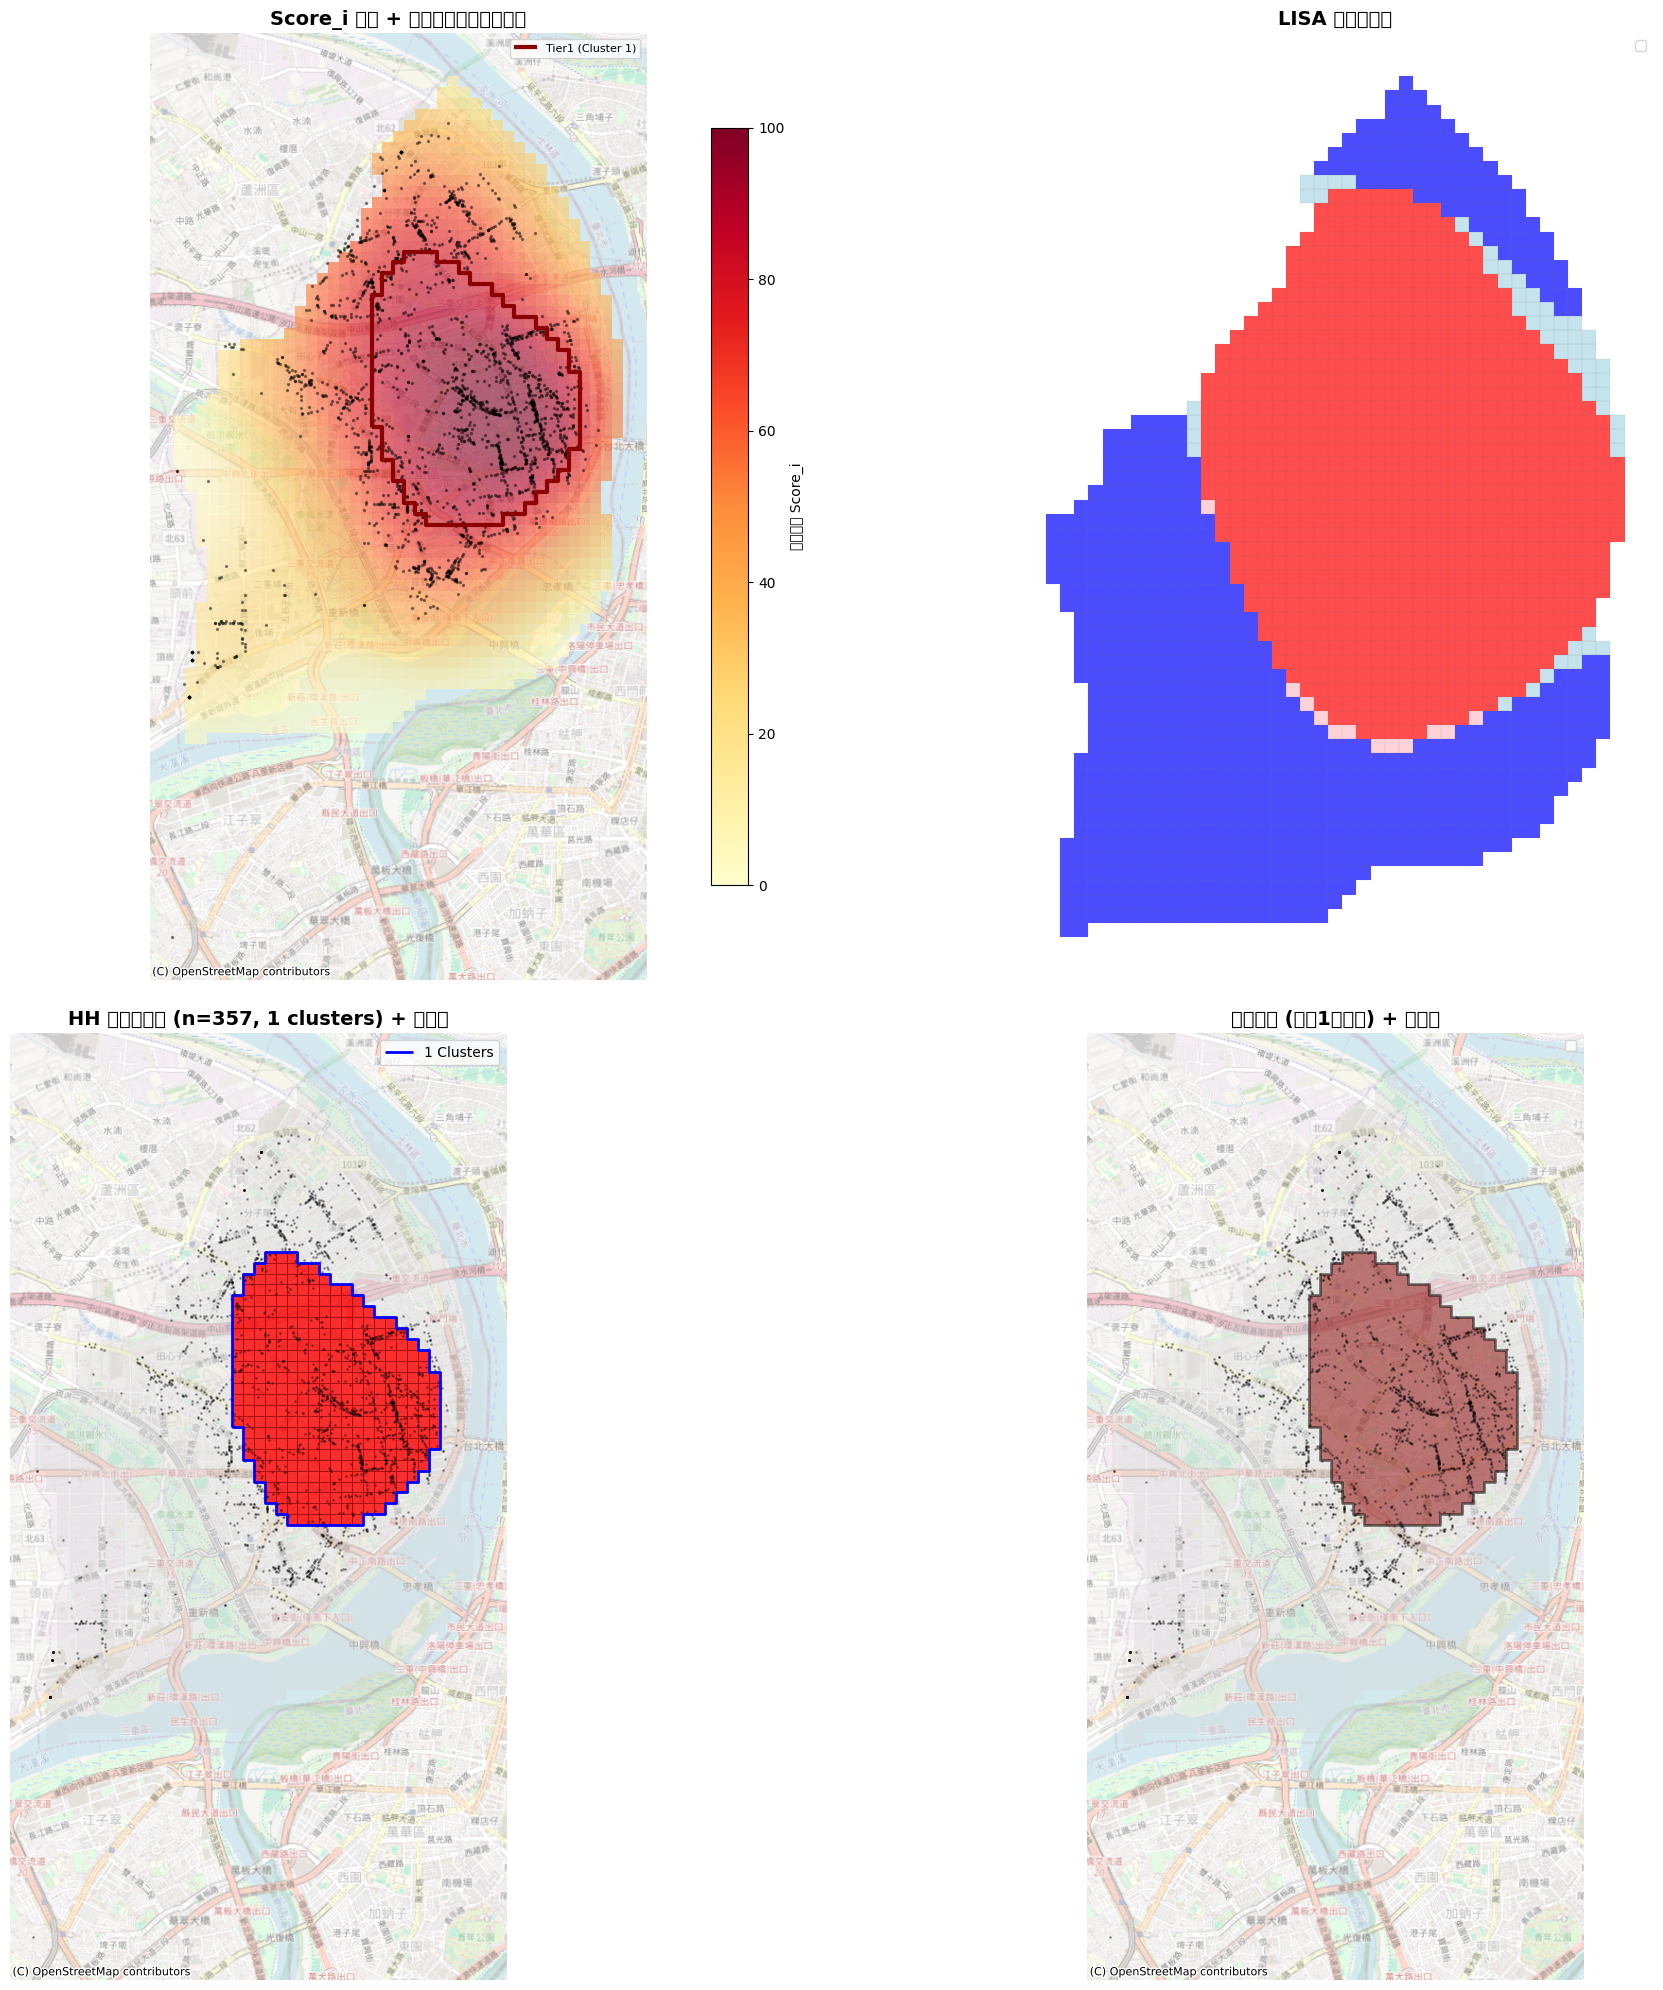


圖例說明:
  黑點: 餐飲POI位置 (共2155筆)
  紅色區域: Tier1 核心商圈
  橘色區域: Tier2 區域商圈
  總商圈數: 1
  總Cluster數: 1
  底圖: OpenStreetMap 街道圖


In [25]:
try:
    import contextily as cx
    use_basemap = True
except ImportError:
    print("警告: contextily 未安裝，將不顯示街道圖底圖")
    print("請執行: pip install contextily")
    use_basemap = False

# 建立視覺化
fig, axes = plt.subplots(2, 2, figsize=(24, 20))

# 1. Score_i 分布（帶街道圖）- 全部網格漸層
ax1 = axes[0, 0]
grid_with_kde.plot(column='Score_i', cmap='YlOrRd', legend=True, ax=ax1, 
                    edgecolor='none', alpha=0.6, vmin=0, vmax=100,
                    legend_kwds={'label': '餐飲火力 Score_i', 'shrink': 0.8})
# 繪製所有商圈邊界
if len(circles) > 0:
    for idx, row in circles.iterrows():
        color = 'darkred' if row['tier'] == 'Tier1' else 'orange'
        gpd.GeoSeries([row.geometry], crs=circles.crs).boundary.plot(
            ax=ax1, color=color, linewidth=3, label=f"{row['tier']} (Cluster {row['cluster_id']})")
# 繪製POI
catering_anlyzed.plot(ax=ax1, color='black', markersize=2, alpha=0.4)
if use_basemap:
    cx.add_basemap(ax1, crs=grid_with_kde.crs.to_string(), 
                   source=cx.providers.OpenStreetMap.Mapnik, alpha=0.5)
ax1.set_title('Score_i 分布 + 商圈邊界（含街道圖）', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right', fontsize=8)
ax1.axis('off')

# 2. LISA 四象限
ax2 = axes[0, 1]
quadrant_colors = {'HH': 'red', 'HL': 'pink', 'LH': 'lightblue', 'LL': 'blue', 'Non-significant': 'white'}
for quad, color in quadrant_colors.items():
    subset = grid_with_kde[grid_with_kde['quadrant'] == quad]
    if len(subset) > 0:
        subset.plot(ax=ax2, color=color, edgecolor='gray', linewidth=0.1, alpha=0.7, label=quad)
ax2.legend(loc='upper right')
ax2.set_title('LISA 四象限分類', fontsize=14, fontweight='bold')
ax2.axis('off')

# 3. HH格子（帶街道圖）
ax3 = axes[1, 0]
grid_with_kde.plot(ax=ax3, color='lightgray', edgecolor='white', linewidth=0.1, alpha=0.3)
hh_grids = grid_with_kde[grid_with_kde['HH_flag']]
if len(hh_grids) > 0:
    hh_grids.plot(ax=ax3, color='red', edgecolor='darkred', linewidth=0.5, alpha=0.8)
# 繪製所有cluster邊界
if len(clusters) > 0:
    clusters.boundary.plot(ax=ax3, color='blue', linewidth=2, label=f'{len(clusters)} Clusters')
# 繪製POI
catering_anlyzed.plot(ax=ax3, color='black', markersize=1, alpha=0.3)
if use_basemap:
    cx.add_basemap(ax3, crs=grid_with_kde.crs.to_string(), 
                   source=cx.providers.OpenStreetMap.Mapnik, alpha=0.5)
ax3.set_title(f'HH 高值聚集區 (n={len(hh_grids)}, {len(clusters)} clusters) + 街道圖', 
              fontsize=14, fontweight='bold')
ax3.legend(loc='upper right')
ax3.axis('off')

# 4. 商圈分級（帶街道圖）
ax4 = axes[1, 1]
grid_with_kde.plot(ax=ax4, color='lightgray', edgecolor='white', linewidth=0.1, alpha=0.3)
if len(circles) > 0:
    tier_colors = {'Tier1': 'darkred', 'Tier2': 'orange'}
    for tier, color in tier_colors.items():
        subset = circles[circles['tier'] == tier]
        if len(subset) > 0:
            subset.plot(ax=ax4, facecolor=color, edgecolor='black', linewidth=2, 
                       alpha=0.5, label=f'{tier} ({len(subset)}個)')
# 繪製POI
catering_anlyzed.plot(ax=ax4, color='black', markersize=1, alpha=0.3)
if use_basemap:
    cx.add_basemap(ax4, crs=grid_with_kde.crs.to_string(), 
                   source=cx.providers.OpenStreetMap.Mapnik, alpha=0.5)
ax4.legend(loc='upper right')
ax4.set_title(f'商圈分級 (總計{len(circles)}個商圈) + 街道圖', fontsize=14, fontweight='bold')
ax4.axis('off')

plt.tight_layout()
plt.show()

print(f"\n圖例說明:")
print(f"  黑點: 餐飲POI位置 (共{len(catering_anlyzed)}筆)")
print(f"  紅色區域: Tier1 核心商圈")
print(f"  橘色區域: Tier2 區域商圈")
print(f"  總商圈數: {len(circles)}")
print(f"  總Cluster數: {len(clusters)}")
if use_basemap:
    print(f"  底圖: OpenStreetMap 街道圖")

HH核心區統計:
  格子數: 357
  Score_i 範圍: 78.9 - 100.0
  Score_i 平均: 89.5
  分位數:
    Q25: 84.2
    Q50: 89.5
    Q75: 94.7


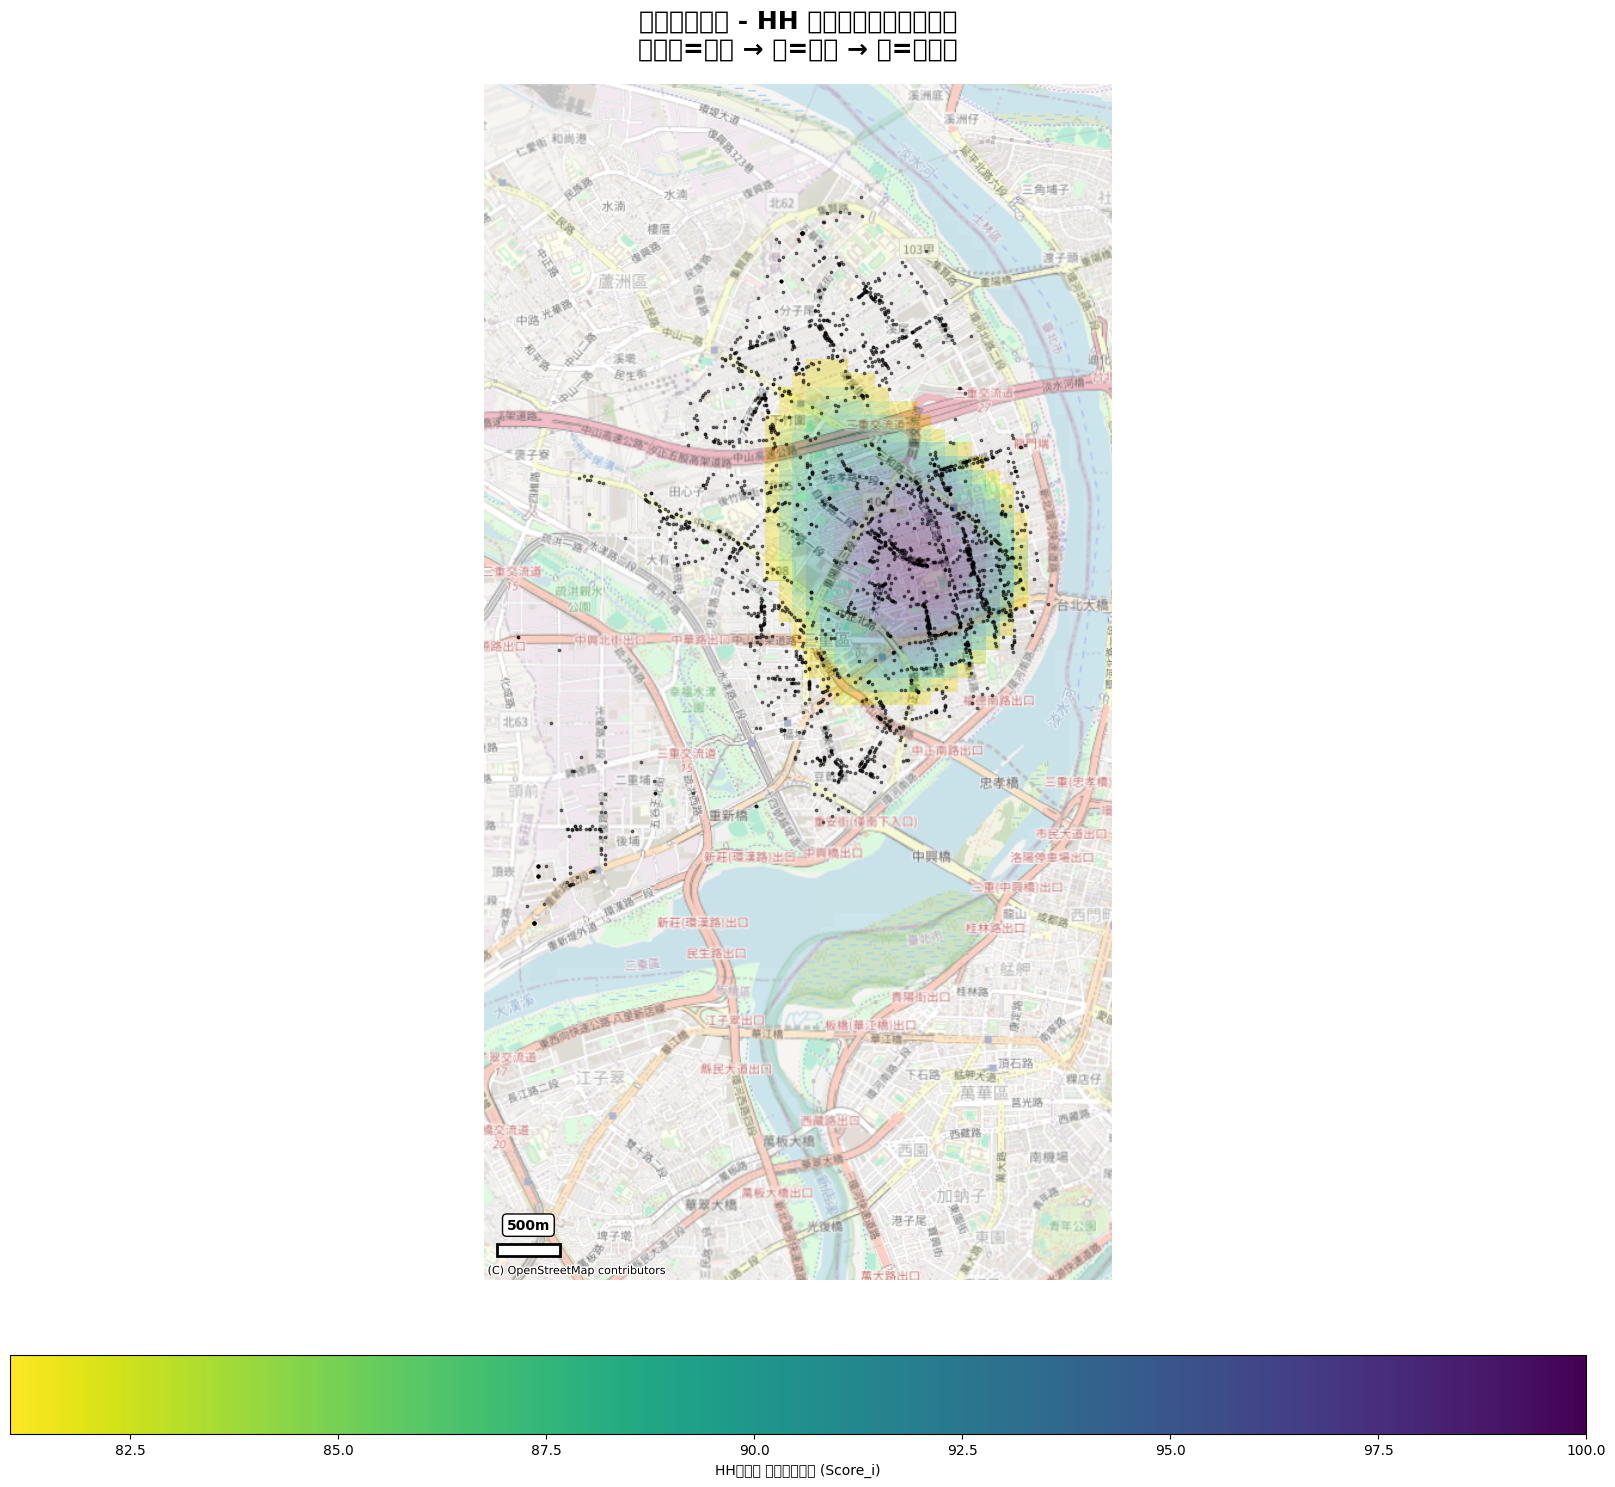


圖例說明:
  🔵 深藍色: 餐飲火力最強的核心區域（Score_i > 94.73684210526315）
  🟢 綠色: 餐飲火力中等的核心區域
  🟡 黃色: 餐飲火力較弱的核心區域
  ⚫ 黑點: 餐飲POI位置 (共2155筆)
  🗺️ 底圖: OpenStreetMap 街道圖


In [26]:
# HH 核心區域漸層圖（獨立大圖）
fig, ax = plt.subplots(1, 1, figsize=(20, 16))

# 底層：所有網格淡色背景
grid_with_kde.plot(ax=ax, color='whitesmoke', edgecolor='white', linewidth=0.1, alpha=0.5)

# 核心層：HH格子依 Score_i 顯示藍→綠→黃漸層
hh_grids = grid_with_kde[grid_with_kde['HH_flag']]

if len(hh_grids) > 0:
    # 使用 YlGnBu_r 色階（反轉）：深藍(高分) -> 綠 -> 黃(低分)
    # 或使用 viridis_r：深藍紫(高分) -> 綠 -> 黃(低分)
    hh_grids.plot(column='Score_i', cmap='viridis_r', ax=ax, 
                  edgecolor='none', linewidth=0, alpha=0.9,
                  legend=True, 
                  legend_kwds={
                      'label': 'HH核心區 餐飲火力指數 (Score_i)', 
                      'shrink': 0.8,
                      'orientation': 'horizontal',
                      'pad': 0.05
                  },
                  vmin=hh_grids['Score_i'].quantile(0.1),  # 最小值用10分位
                  vmax=hh_grids['Score_i'].max())           # 最大值
    
    print(f"HH核心區統計:")
    print(f"  格子數: {len(hh_grids)}")
    print(f"  Score_i 範圍: {hh_grids['Score_i'].min():.1f} - {hh_grids['Score_i'].max():.1f}")
    print(f"  Score_i 平均: {hh_grids['Score_i'].mean():.1f}")
    print(f"  分位數:")
    print(f"    Q25: {hh_grids['Score_i'].quantile(0.25):.1f}")
    print(f"    Q50: {hh_grids['Score_i'].quantile(0.50):.1f}")
    print(f"    Q75: {hh_grids['Score_i'].quantile(0.75):.1f}")
else:
    print("警告：沒有HH核心區")

# 繪製餐飲POI（黑色小點）
catering_anlyzed.plot(ax=ax, color='black', markersize=3, alpha=0.5, zorder=3)

# 添加街道圖底圖
if use_basemap:
    try:
        cx.add_basemap(ax, crs=grid_with_kde.crs.to_string(), 
                       source=cx.providers.OpenStreetMap.Mapnik, 
                       alpha=0.6, zorder=1)
    except Exception as e:
        print(f"底圖載入失敗: {e}")

# 設定標題和樣式
ax.set_title(f'{TARGET_COUNTY}{TARGET_TOWN} - HH 餐飲商業核心區火力圖\n（深藍=最強 → 綠=中等 → 黃=較弱）', 
             fontsize=18, fontweight='bold', pad=20)
ax.axis('off')

# 添加比例尺
from matplotlib.patches import Rectangle

scale_length = 500  # 500公尺
ax.add_patch(Rectangle((0.02, 0.02), 0.1, 0.01, transform=ax.transAxes, 
                       facecolor='white', edgecolor='black', linewidth=2))
ax.text(0.07, 0.04, f'{scale_length}m', transform=ax.transAxes, 
        ha='center', va='bottom', fontsize=10, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black'))

plt.tight_layout()
plt.show()

print(f"\n圖例說明:")
print(f"  🔵 深藍色: 餐飲火力最強的核心區域（Score_i > {hh_grids['Score_i'].quantile(0.75) if len(hh_grids) > 0 else 'N/A'}）")
print(f"  🟢 綠色: 餐飲火力中等的核心區域")
print(f"  🟡 黃色: 餐飲火力較弱的核心區域")
print(f"  ⚫ 黑點: 餐飲POI位置 (共{len(catering_anlyzed)}筆)")
if use_basemap:
    print(f"  🗺️ 底圖: OpenStreetMap 街道圖")

## 7. 敏感度分析

測試不同參數組合的穩定性

In [ ]:
def run_full_analysis(grid_raw_df, grid_geo_df, h=600, d0=900, alpha=1):
    """
    執行完整分析流程
    
    參數:
        grid_raw_df: 包含grid_id和raw_i的DataFrame
        grid_geo_df: 包含幾何資訊的GeoDataFrame
        h: KDE頻寬
        d0: LISA距離閾值
        alpha: 距離衰減參數
    
    返回:
        circles GeoDataFrame
    """
    # 合併資料
    analysis_grid = grid_geo_df.merge(grid_raw_df, on='grid_id', how='left')
    analysis_grid['raw_i'] = analysis_grid['raw_i'].fillna(0)
    
    # 計算中心點
    analysis_grid['centroid'] = analysis_grid.geometry.centroid
    analysis_grid['centroid_x'] = analysis_grid['centroid'].x
    analysis_grid['centroid_y'] = analysis_grid['centroid'].y
    
    # KDE
    analysis_grid = compute_kde_density(analysis_grid, bandwidth=h)
    analysis_grid['rank_pct'] = analysis_grid['D_i'].rank(pct=True)
    analysis_grid['Score_i'] = analysis_grid['rank_pct'] * 100
    
    # LISA
    analysis_grid['z_i'] = zscore(analysis_grid['Score_i'])
    w = create_distance_decay_weights(analysis_grid, threshold=d0, alpha=alpha)
    lisa = Moran_Local(analysis_grid['z_i'].values, w, permutations=999)
    
    analysis_grid['I_i'] = lisa.Is
    analysis_grid['p_value'] = lisa.p_sim
    
    # 計算空間滯後值
    z_values = analysis_grid['z_i'].values
    lag_z = np.zeros(len(z_values))
    for i in range(len(z_values)):
        if i in w.neighbors:
            neighbors = w.neighbors[i]
            weights = w.weights[i]
            lag_z[i] = sum(weights[j] * z_values[neighbors[j]] for j in range(len(neighbors)))
    analysis_grid['lag_z_i'] = lag_z
    
    quadrant_map = {1: 'HH', 2: 'LH', 3: 'LL', 4: 'HL', 0: 'Non-significant'}
    analysis_grid['quadrant'] = [quadrant_map.get(q, 'Non-significant') for q in lisa.q]
    
    # FDR校正
    reject, q_values, _, _ = multipletests(analysis_grid['p_value'], method='fdr_bh')
    analysis_grid['q_value'] = q_values
    
    # HH篩選
    analysis_grid['HH_flag'] = (
        (analysis_grid['quadrant'] == 'HH') &
        (analysis_grid['z_i'] > 0) &
        (analysis_grid['lag_z_i'] > 0) &
        (analysis_grid['q_value'] < 0.05)
    )
    
    # Clusters
    hh_grids = analysis_grid[analysis_grid['HH_flag']].copy()
    
    if len(hh_grids) == 0:
        return gpd.GeoDataFrame(columns=['cluster_id', 'tier', 'N_grids', 'TotalPower'], crs=analysis_grid.crs)
    
    clusters_dissolved = hh_grids.dissolve()
    clusters_list = []
    for idx, row in clusters_dissolved.iterrows():
        geom = row.geometry
        if geom.geom_type == 'MultiPolygon':
            for poly in geom.geoms:
                clusters_list.append({'geometry': poly})
        else:
            clusters_list.append({'geometry': geom})
    
    clusters = gpd.GeoDataFrame(clusters_list, crs=hh_grids.crs)
    clusters['cluster_id'] = range(1, len(clusters) + 1)
    
    # 統計
    hh_with_cluster = gpd.sjoin(hh_grids, clusters[['cluster_id', 'geometry']], how='left', predicate='within')
    cluster_stats = hh_with_cluster.groupby('cluster_id').agg({
        'grid_id': 'count',
        'Score_i': ['sum', 'max'],
    }).reset_index()
    cluster_stats.columns = ['cluster_id', 'N_grids', 'TotalPower', 'Peak']
    
    clusters = clusters.merge(cluster_stats, on='cluster_id', how='left')
    
    # 分級
    if len(clusters) > 0:
        p90_totalpower = clusters['TotalPower'].quantile(0.9)
        mean_totalpower = clusters['TotalPower'].mean()
        
        def classify_tier(row):
            if row['N_grids'] >= 10 and row['TotalPower'] >= p90_totalpower:
                return 'Tier1'
            elif row['N_grids'] >= 4 and row['TotalPower'] >= mean_totalpower:
                return 'Tier2'
            else:
                return 'Non-Circle'
        
        clusters['tier'] = clusters.apply(classify_tier, axis=1)
        circles = clusters[clusters['tier'] != 'Non-Circle'].copy()
    else:
        circles = gpd.GeoDataFrame(columns=['cluster_id', 'tier', 'N_grids', 'TotalPower'], crs=analysis_grid.crs)
    
    return circles

def run_full_analysis_detailed(grid_raw_df, grid_geo_df, h=600, d0=900, alpha=1, top_n=5):
    """執行完整流程並回傳敏感度分析所需的中間結果。"""
    # 先跑完整流程（複用 run_full_analysis 的邏輯，但保留中間結果）
    analysis_grid = grid_geo_df.merge(grid_raw_df, on='grid_id', how='left')
    analysis_grid['raw_i'] = analysis_grid['raw_i'].fillna(0)

    analysis_grid['centroid'] = analysis_grid.geometry.centroid
    analysis_grid['centroid_x'] = analysis_grid['centroid'].x
    analysis_grid['centroid_y'] = analysis_grid['centroid'].y

    # KDE
    analysis_grid = compute_kde_density(analysis_grid, bandwidth=h)
    analysis_grid['rank_pct'] = analysis_grid['D_i'].rank(pct=True)
    analysis_grid['Score_i'] = analysis_grid['rank_pct'] * 100

    # LISA
    analysis_grid['z_i'] = zscore(analysis_grid['Score_i'])
    w = create_distance_decay_weights(analysis_grid, threshold=d0, alpha=alpha)
    lisa = Moran_Local(analysis_grid['z_i'].values, w, permutations=999)

    analysis_grid['I_i'] = lisa.Is
    analysis_grid['p_value'] = lisa.p_sim

    # 空間滯後值 lag_z_i
    z_values = analysis_grid['z_i'].values
    lag_z = np.zeros(len(z_values))
    for i in range(len(z_values)):
        if i in w.neighbors:
            neighbors = w.neighbors[i]
            weights = w.weights[i]
            lag_z[i] = sum(weights[j] * z_values[neighbors[j]] for j in range(len(neighbors)))
    analysis_grid['lag_z_i'] = lag_z

    quadrant_map = {1: 'HH', 2: 'LH', 3: 'LL', 4: 'HL', 0: 'Non-significant'}
    analysis_grid['quadrant'] = [quadrant_map.get(q, 'Non-significant') for q in lisa.q]

    # BH-FDR
    _, q_values, _, _ = multipletests(analysis_grid['p_value'], method='fdr_bh')
    analysis_grid['q_value'] = q_values

    # HH 篩選（README）
    analysis_grid['HH_flag'] = (
        (analysis_grid['quadrant'] == 'HH') &
        (analysis_grid['z_i'] > 0) &
        (analysis_grid['lag_z_i'] > 0) &
        (analysis_grid['q_value'] < 0.05)
    )

    hh_grids = analysis_grid[analysis_grid['HH_flag']].copy()
    hh_grid_ids = set(hh_grids['grid_id'].tolist())

    if len(hh_grids) == 0:
        empty = gpd.GeoDataFrame(columns=['cluster_id', 'tier', 'N_grids', 'TotalPower', 'Peak', 'geometry'], crs=analysis_grid.crs)
        return {
            'analysis_grid': analysis_grid,
            'clusters': empty,
            'circles': empty,
            'hh_grid_ids': hh_grid_ids,
            'topN_hh_grid_ids': set(),
        }

    # Clusters：dissolve 後拆 MultiPolygon
    clusters_dissolved = hh_grids.dissolve()
    clusters_list = []
    for _, row in clusters_dissolved.iterrows():
        geom = row.geometry
        if geom.geom_type == 'MultiPolygon':
            for poly in geom.geoms:
                clusters_list.append({'geometry': poly})
        else:
            clusters_list.append({'geometry': geom})

    clusters = gpd.GeoDataFrame(clusters_list, crs=hh_grids.crs)
    clusters['cluster_id'] = range(1, len(clusters) + 1)

    # 統計 cluster attributes
    hh_with_cluster = gpd.sjoin(hh_grids, clusters[['cluster_id', 'geometry']], how='left', predicate='within')
    cluster_stats = hh_with_cluster.groupby('cluster_id').agg({
        'grid_id': 'count',
        'Score_i': ['sum', 'max'],
    }).reset_index()
    cluster_stats.columns = ['cluster_id', 'N_grids', 'TotalPower', 'Peak']
    clusters = clusters.merge(cluster_stats, on='cluster_id', how='left')

    # 分級（README）
    p90_totalpower = clusters['TotalPower'].quantile(0.9)
    mean_totalpower = clusters['TotalPower'].mean()

    def classify_tier(row):
        if row['N_grids'] >= 10 and row['TotalPower'] >= p90_totalpower:
            return 'Tier1'
        if row['N_grids'] >= 4 and row['TotalPower'] >= mean_totalpower:
            return 'Tier2'
        return 'Non-Circle'

    clusters['tier'] = clusters.apply(classify_tier, axis=1)
    circles = clusters[clusters['tier'] != 'Non-Circle'].copy()

    # Top-N circles 重疊率：以 Top-N circles 的 HH grid_id 集合作為比較基礎
    if len(circles) > 0:
        top_cluster_ids = circles.nlargest(top_n, 'TotalPower')['cluster_id']
    else:
        top_cluster_ids = clusters.nlargest(top_n, 'TotalPower')['cluster_id']
    top_hh_grid_ids = set(hh_with_cluster.loc[hh_with_cluster['cluster_id'].isin(top_cluster_ids), 'grid_id'].tolist())

    return {
        'analysis_grid': analysis_grid,
        'clusters': clusters,
        'circles': circles,
        'hh_grid_ids': hh_grid_ids,
        'topN_hh_grid_ids': top_hh_grid_ids,
    }

print("敏感度分析函數定義完成")

In [ ]:
# 敏感度/穩健性報表（依 README 的最小參數矩陣）
import json

param_combinations = [
    {'h': h, 'd0': d0, 'alpha': alpha}
    for h in [450, 600]
    for d0 in [600, 900, 1200]
    for alpha in [1, 2]
]

baseline_params = {'h': 600, 'd0': 900, 'alpha': 1}
top_n = 5

def get_primary_variation_driver(params, baseline):
    if params['h'] != baseline['h']:
        return 'kde_bandwidth_h_m'
    if params['d0'] != baseline['d0']:
        return 'lisa_d0_m'
    if params['alpha'] != baseline['alpha']:
        return 'lisa_alpha'
    return 'baseline'

print("開始敏感度分析...")
baseline = run_full_analysis_detailed(
    grid_raw_df=grid_raw[['grid_id', 'raw_i']],
    grid_geo_df=grid_target[['grid_id', 'geometry', 'TOWNNAME']],
    h=baseline_params['h'],
    d0=baseline_params['d0'],
    alpha=baseline_params['alpha'],
    top_n=top_n,
)

baseline_scores = baseline['analysis_grid'].set_index('grid_id')['Score_i']
baseline_top = baseline['topN_hh_grid_ids']

sensitivity_results = []
for i, params in enumerate(param_combinations, start=1):
    print(f"\n[{i}/{len(param_combinations)}] h={params['h']}, d0={params['d0']}, alpha={params['alpha']}")

    res = run_full_analysis_detailed(
        grid_raw_df=grid_raw[['grid_id', 'raw_i']],
        grid_geo_df=grid_target[['grid_id', 'geometry', 'TOWNNAME']],
        h=params['h'],
        d0=params['d0'],
        alpha=params['alpha'],
        top_n=top_n,
    )

    # Top-N circles 重疊率（以 Top-N circles 的 HH grid_id 集合作為比較基礎）
    current_top = res['topN_hh_grid_ids']
    union = baseline_top | current_top
    topN_jaccard = (len(baseline_top & current_top) / len(union)) if len(union) > 0 else 1.0

    # circles 排名穩定度（以所有 grid 的 Score_i Spearman 相關作為 proxy）
    current_scores = res['analysis_grid'].set_index('grid_id')['Score_i']
    rank_spearman = baseline_scores.corr(current_scores, method='spearman')

    row = {
        'run_id': f"h={params['h']}_d0={params['d0']}_alpha={params['alpha']}",
        'params': json.dumps(params, ensure_ascii=False),
        'circle_count': int(len(res['circles'])),
        'topN_jaccard': float(topN_jaccard),
        'rank_spearman': float(rank_spearman) if rank_spearman is not None else None,
        'hh_grid_count': int(len(res['hh_grid_ids'])),
        'cluster_count': int(len(res['clusters'])),
        'primary_variation_driver': get_primary_variation_driver(params, baseline_params),
    }
    sensitivity_results.append(row)

    print(f"  circles={row['circle_count']}, clusters={row['cluster_count']}, HH_grids={row['hh_grid_count']}, topN_jaccard={row['topN_jaccard']:.3f}, spearman={row['rank_spearman']:.3f}")

sensitivity_df = pd.DataFrame(sensitivity_results)
print("\n=== 敏感度/穩健性報表 ===")
print(sensitivity_df.to_string(index=False))

## 8. 儲存結果

In [ ]:
# 儲存主要結果
output_dir = Path(r"C:\labs\geo-grid\data\output_analysis")
output_dir.mkdir(parents=True, exist_ok=True)
output_slug = f"{TARGET_COUNTY}_{TARGET_TOWN}"

# 1. 儲存grid分析結果
grid_analysis_path = output_dir / f"grid_{output_slug}_analysis.parquet"
grid_with_kde.to_parquet(grid_analysis_path)
print(f"網格分析結果已儲存: {grid_analysis_path}")

# 2. 儲存clusters
if len(clusters) > 0:
    clusters_path = output_dir / f"clusters_{output_slug}.parquet"
    clusters.to_parquet(clusters_path)
    print(f"Clusters已儲存: {clusters_path}")

# 3. 儲存circles
if len(circles) > 0:
    circles_path = output_dir / f"circles_{output_slug}.parquet"
    circles.to_parquet(circles_path)
    print(f"商圈結果已儲存: {circles_path}")

# 4. 儲存敏感度分析報表
sensitivity_path = output_dir / "sensitivity_report.csv"
sensitivity_df.to_csv(sensitivity_path, index=False, encoding='utf-8-sig')
print(f"敏感度分析報表已儲存: {sensitivity_path}")

print("\n所有結果已儲存完成！")

## 總結

本分析流程完成了以下步驟：

1. **POI特徵工程**: 將餐飲POI分類為目的型/補給型，設定權重與cap值，計算每格的raw_i分數
2. **空間對位**: 將POI與100m網格進行空間join，統計每格的餐飲業態分布
3. **KDE密度估計**: 使用網格中心點和raw_i權重計算平滑的餐飲火力密度場，轉換為0-100分的Score_i
4. **LISA分析**: 建立距離衰減權重矩陣，計算Local Moran's I，識別HH (High-High)聚集區
5. **多重比較校正**: 使用BH-FDR方法校正p-value，降低假陽性率
6. **商業區生成**: 將HH格子dissolve成連續的clusters，計算規模與火力屬性
7. **商圈分級**: 根據網格數與總火力將clusters分為Tier1 (核心商圈) 和 Tier2 (區域商圈)
8. **敏感度分析**: 測試不同KDE頻寬(h)、LISA距離閾值(d0)、距離衰減參數(alpha)對結果的影響

### 主要發現 (以新莊區為例)
- HH格子數量: [執行後顯示]
- 商圈總數: [執行後顯示]
- Tier1 商圈: [執行後顯示]
- Tier2 商圈: [執行後顯示]

### 參數建議
- KDE頻寬: 600m (可視情況調整至450m)
- LISA距離閾值: 900m
- 距離衰減: alpha=1 (線性衰減)

### 後續可延伸方向
1. 擴展至其他行政區進行比較分析
2. 結合其他POI類別（零售、娛樂等）進行多維度分析
3. 時間序列分析（比較不同時期的商圈變化）
4. 與實際商圈資料進行驗證與校準

### 6.4 多商業區漸層圖（顯示所有 Clusters）

In [ ]:
# 多商業區漸層圖（獨立大圖）
fig, ax = plt.subplots(1, 1, figsize=(20, 16))

# 底層：所有網格淡色背景
grid_with_kde.plot(ax=ax, color='whitesmoke', edgecolor='white', linewidth=0.1, alpha=0.5)

# 核心層：HH格子依 Score_i 顯示藍→綠→黃漸層
hh_grids = grid_with_kde[grid_with_kde['HH_flag']]

if len(hh_grids) > 0:
    # 使用 viridis_r 色階：深藍(高分) -> 綠 -> 黃(低分)
    hh_grids.plot(column='Score_i', cmap='viridis_r', ax=ax, 
                  edgecolor='black', linewidth=0.5, alpha=0.9,
                  legend=True, 
                  legend_kwds={
                      'label': 'HH核心區 餐飲火力指數 (Score_i)', 
                      'shrink': 0.8,
                      'orientation': 'horizontal',
                      'pad': 0.05
                  },
                  vmin=hh_grids['Score_i'].quantile(0.1),
                  vmax=hh_grids['Score_i'].max())
    
    print(f"HH核心區統計:")
    print(f"  總格子數: {len(hh_grids)}")
    print(f"  Clusters數: {len(clusters)}")
    print(f"  Score_i 範圍: {hh_grids['Score_i'].min():.1f} - {hh_grids['Score_i'].max():.1f}")
    
    # 顯示每個cluster的統計
    if len(clusters) > 0:
        print(f"\n各 Cluster 資訊:")
        for idx, row in clusters.iterrows():
            print(f"  Cluster {row['cluster_id']}: {row['n_grids_in_cluster']}格")
else:
    print("警告：沒有HH核心區")

# 繪製cluster邊界（不同顏色）
if len(clusters) > 1:
    colors = ['blue', 'cyan', 'green', 'magenta', 'orange']
    for idx, row in clusters.iterrows():
        color = colors[idx % len(colors)]
        gpd.GeoSeries([row.geometry], crs=clusters.crs).boundary.plot(
            ax=ax, color=color, linewidth=3, linestyle='--', 
            label=f'Cluster {row["cluster_id"]}', zorder=5)

# 繪製餐飲POI（黑色小點）
catering_anlyzed.plot(ax=ax, color='black', markersize=2, alpha=0.4, zorder=3)

# 添加街道圖底圖
if use_basemap:
    try:
        cx.add_basemap(ax, crs=grid_with_kde.crs.to_string(), 
                       source=cx.providers.OpenStreetMap.Mapnik, 
                       alpha=0.6, zorder=1)
    except Exception as e:
        print(f"底圖載入失敗: {e}")

# 設定標題和樣式
ax.set_title(f'{TARGET_COUNTY}{TARGET_TOWN} - 餐飲商業區分布圖 ({len(clusters)} 個獨立商業區)\n（深藍=最強 → 綠=中等 → 黃=較弱）', 
             fontsize=18, fontweight='bold', pad=20)
if len(clusters) > 1:
    ax.legend(loc='upper right', fontsize=12, framealpha=0.9)
ax.axis('off')

# 添加比例尺
from matplotlib.patches import Rectangle

scale_length = 500  # 500公尺
ax.add_patch(Rectangle((0.02, 0.02), 0.1, 0.01, transform=ax.transAxes, 
                       facecolor='white', edgecolor='black', linewidth=2))
ax.text(0.07, 0.04, f'{scale_length}m', transform=ax.transAxes, 
        ha='center', va='bottom', fontsize=10, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black'))

plt.tight_layout()
plt.show()

print(f"\n圖例說明:")
print(f"  🔵 深藍色: 餐飲火力最強")
print(f"  🟢 綠色: 餐飲火力中等")
print(f"  🟡 黃色: 餐飲火力較弱")
print(f"  ⬛ 黑色邊線: 100m × 100m 網格")
print(f"  ⚫ 黑點: 餐飲POI位置 (共{len(catering_anlyzed)}筆)")
print(f"  🔷 虛線邊界: 各獨立商業區邊界 (共{len(clusters)}個)")
if use_basemap:
    print(f"  🗺️ 底圖: OpenStreetMap 街道圖")